# Opimization/Regression/Sparisity
Suppose we have input data $\vec{x} = \{x_0,x_1,\dots\}^T$ and output data $f(\vec{x})= \{f(x_0),f(x_1),\dots\}^T$, after some black-box calculation.

We want to fit it with, say, a polynomial or order $n$, such that $P_n(\vec{x})$ is as close to $f(\vec{x})$.

That means we have to find coeficients $\vec{c} = \{c_0,c_1,\dots\}^T$ <br>
to solve equation $$\Phi \vec{c} = \vec{f}$$
$$
\begin{bmatrix}
    x_1^0   & x_1^2 & \dots & x_1^n \\
    x_2^0   & x_2^2 & \dots & x_2^n \\
            &       & \dots &       \\
\end{bmatrix}
\begin{bmatrix}
    c_0\\
    c_1\\
    \dots
\end{bmatrix}=
\begin{bmatrix}
    f(x_1)\\
    f(x_2)\\
    \dots
\end{bmatrix}
$$
for best possible $\vec{c}$<br>
_Which would be an alogue to continuous case_
$$\{c_0,c_1,\dots\} \cdot \{x^0,x^1,\dots\} = c_0 + c_1x^1 + c_2x^2\dots$$

We search for such $\vec{c}^*$, that map $\Phi \vec{c}^*$ is as close to $\vec{f}$ as possible

Or, in other words, $$\|\Phi \vec{c}^* - \vec{f}\|$$ is minimal.

Norm $\|\cdot\|$ will dictate how sparse (how many zeros) solution $\vec{c}$ is. 

_Sparsity of a solution is related to model complexity._

_Model should be as <u>simple as possible</u>, but not so simple that important details are lost. Enough to capture most important trends._<br>

_Dense (non-sparse) solution might <u>overfit</u> data and badly represent extrapolated data (out of training domain)._

## Example

Example take from book "Data Driven Science & Engineering (2017 Brunton & Kutz)" Chapter 4. https://databookuw.com/databook.pdf

Reconstruct parabolic data with noise using polynomial basis.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sklearn import linear_model
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from pylab import rcParams
plt.rcParams['figure.figsize'] = [8, 8]
rcParams.update({'font.size': 8})

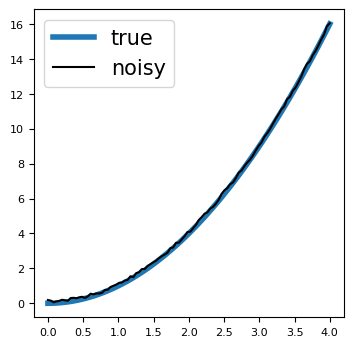

In [25]:

N = 100
x = np.linspace(0,4,N).T
f_x = x*x
f_x2 = x*x + 0.2*np.random.rand(*x.shape)
pl = plt.figure(figsize=(4,4))
plt.plot(x, f_x, label='true', lw = 4)
plt.plot(x, f_x2, label='noisy', c = 'k')
plt.legend(fontsize=15)


['$x^0$', '$x^1$', '$x^2$', '$x^3$', '$x^4$', '$x^5$', '$x^6$', '$x^7$', '$x^8$', '$x^9$', '$x^10$', '$x^11$', '$x^12$', '$x^13$', '$x^14$', '$x^15$', '$x^16$', '$x^17$', '$x^18$', '$x^19$', '$x^20$']


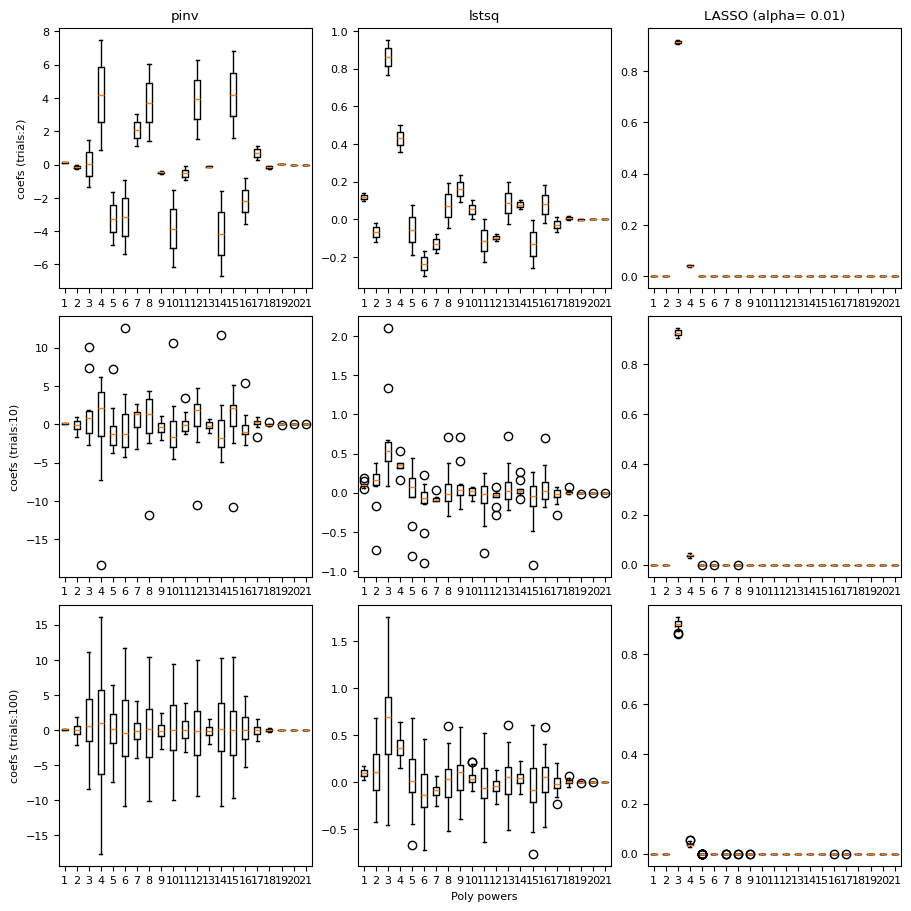

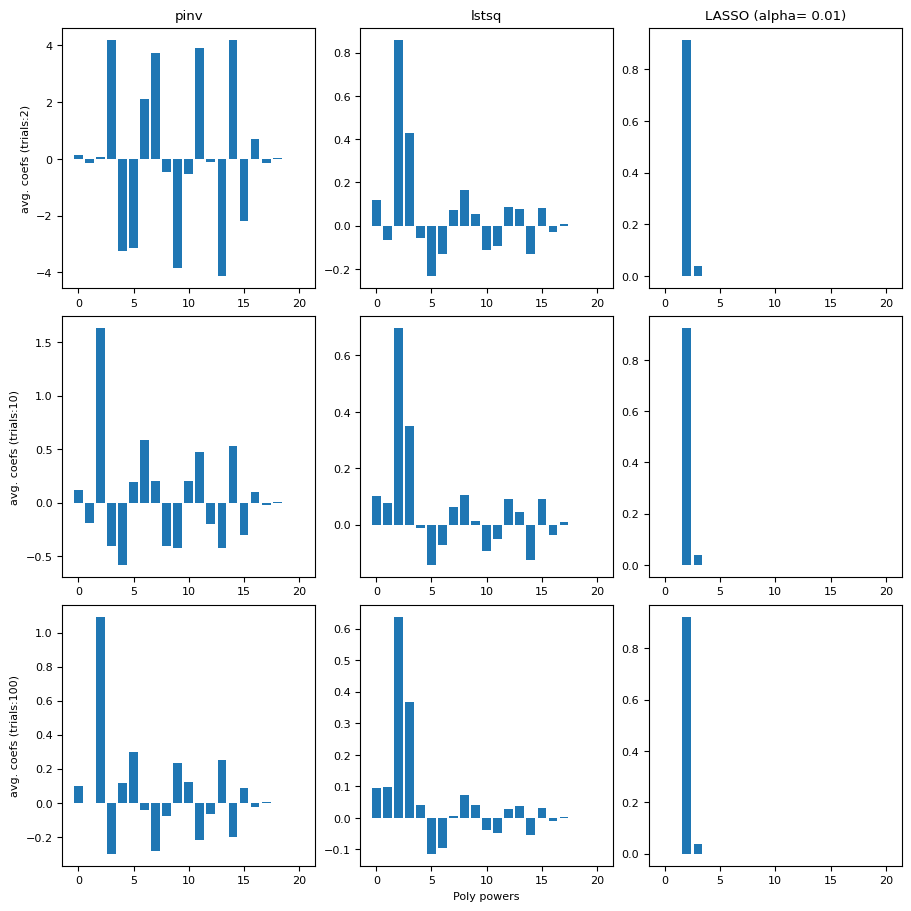

In [9]:

N = 100
x = np.linspace(0,4,N).T
f_x = x*x

q_max = 21 # poly degrees

phi     = np.ones((N,q_max),float)

powers  = []
for i in range(q_max):
    phi[:,i] = x**(i)
    powers.append(rf'$x^{i}$')
#phi[:,0] = np.ones(N)              
print(powers)
num_trials_max = [2, 10, 100]
figsize = (9,3*len(num_trials_max))
fig1,axs = plt.subplots(len(num_trials_max),3, figsize = figsize, layout='constrained')
axs= axs.reshape(-1,3)
fig2,axs2 = plt.subplots(len(num_trials_max),3,figsize = figsize, layout='constrained')
axs2= axs2.reshape(-1,3)
mid_idx = np.floor(len(num_trials_max)/2).astype(int)
for i, tr in enumerate(num_trials_max):
    axs[    i,0].set_ylabel(f'coefs (trials:{tr})')
    axs2[   i,0].set_ylabel(f'avg. coefs (trials:{tr})')
axs[    len(num_trials_max)-1,1].set_xlabel('Poly powers')
axs2[   len(num_trials_max)-1,1].set_xlabel('Poly powers')
axs[0,0].set_title('pinv')
axs[0,1].set_title('lstsq')
axs[0,2].set_title('LASSO (alpha= 0.01)')
axs2[0,0].set_title('pinv')
axs2[0,1].set_title('lstsq')
axs2[0,2].set_title('LASSO (alpha= 0.01)')

for i,trials_max in enumerate(num_trials_max):
    sols1    = np.zeros((q_max,trials_max)  , float)
    sols2    = np.zeros((q_max,trials_max)  , float)
    sols3    = np.zeros((q_max,trials_max)  , float)
    error1   = np.zeros(trials_max      , float)
    error2   = np.zeros(trials_max      , float)
    error3   = np.zeros(trials_max      , float)
    for trial in range(trials_max):
        f_x_noise = (x*x + 0.2*np.random.rand(*x.shape))
        f_x_norm = np.linalg.norm(f_x_noise, ord=2)

        sol1 = np.linalg.pinv(phi) @ f_x_noise
        sols1[:,trial] = sol1
        error1[trial] = np.linalg.norm(phi @ sol1 - f_x_noise, ord=2) / f_x_norm

        sol2 = np.linalg.lstsq(phi, f_x_noise,rcond=None)[0]
        sols2[:,trial] = sol2
        error2[trial] = np.linalg.norm(phi @ sol2 - f_x_noise, ord=2) / f_x_norm

        #regr3 = linear_model.ElasticNet(alpha=1.0, copy_X=True, l1_ratio=0.1, max_iter=10**5,random_state=0)
        regr3 = linear_model.Lasso(alpha=0.01)
        regr3.fit(phi, f_x_noise)  
        a3 = regr3.coef_
        sols3[:,trial] = a3
        error3[trial] = np.linalg.norm(phi @ a3 - f_x_noise, ord=2) / f_x_norm
        a = 1


    axs[i,0].boxplot(sols1.T)
    axs[i,1].boxplot(sols2.T)
    axs[i,2].boxplot(sols3.T)
    bar1 = np.mean(sols1, axis = 1)
    bar2 = np.mean(sols2, axis = 1)
    bar3 = np.mean(sols3, axis = 1)
    axs2[i,0].bar(range(len(bar1)), bar1)
    axs2[i,1].bar(range(len(bar1)), bar2)
    axs2[i,2].bar(range(len(bar1)), bar3)
        